# Elo Merchant Category Recommendation
[Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation)

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

## 4. kernel by Konrad Banachewicz
[LGB + FE (LB 3.707)](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import os

from sklearn.model_selection import KFold

import time
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
print("Shape of train data: " + str(train.shape))
test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
print("Shape of test data: " + str(test.shape))

ht = pd.read_csv("input/historical_transactions.csv")

Shape of train data: (201917, 6)
Shape of test data: (123623, 5)


In [3]:
import datetime

for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['start_year'] = df['first_active_month'].dt.year
    df['start_month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

ytrain = train['target']
del train['target']

In [4]:
ht['authorized_flag'] = ht['authorized_flag'].map({'Y':1, 'N':0})
ht['category_1'] = ht['category_1'].map({'Y':1, 'N':0})

In [5]:
ht['category_2x1'] = (ht['category_2'] == 1) + 0
ht['category_2x2'] = (ht['category_2'] == 2) + 0
ht['category_2x3'] = (ht['category_2'] == 3) + 0
ht['category_2x4'] = (ht['category_2'] == 4) + 0
ht['category_2x5'] = (ht['category_2'] == 5) + 0

In [6]:
ht['category_3A'] = (ht['category_3'].astype(str) == 'A') + 0
ht['category_3B'] = (ht['category_3'].astype(str) == 'B') + 0
ht['category_3C'] = (ht['category_3'].astype(str) == 'C') + 0

In [7]:
def aggregate_historical_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9

    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2': ['nunique'],
        'category_3A': ['sum'],
        'category_3B': ['sum'],
        'category_3C': ['sum'],
        'category_2x1': ['sum','mean'],
        'category_2x2': ['sum','mean'],
        'category_2x3': ['sum','mean'],
        'category_2x4': ['sum','mean'],
        'category_2x5': ['sum','mean'],        
        'city_id': ['nunique'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['min', 'max'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique']
    }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)

    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')

    return agg_history

history = aggregate_historical_transactions(ht)

del ht
gc.collect()

194

In [8]:
new_merchant = pd.read_csv("input/new_merchant_transactions.csv")

In [9]:
new_merchant[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [10]:
new_merchant['authorized_flag'] = new_merchant['authorized_flag'].map({'Y':1, 'N':0})

new_merchant['category_1'] = new_merchant['category_1'].map({'Y':1, 'N':0})
new_merchant['category_3A'] = (new_merchant['category_3'].astype(str) == 'A') + 0
new_merchant['category_3B'] = (new_merchant['category_3'].astype(str) == 'B') + 0
new_merchant['category_3C'] = (new_merchant['category_3'].astype(str) == 'C') + 0

new_merchant['category_2x1'] = (new_merchant['category_2'] == 1) + 0
new_merchant['category_2x2'] = (new_merchant['category_2'] == 2) + 0
new_merchant['category_2x3'] = (new_merchant['category_2'] == 3) + 0
new_merchant['category_2x4'] = (new_merchant['category_2'] == 4) + 0
new_merchant['category_2x5'] = (new_merchant['category_2'] == 5) + 0

In [11]:
new_merchant['purchase_date'] = pd.DatetimeIndex(new_merchant['purchase_date']).astype(np.int64) * 1e-9

In [12]:
def aggregate_new_transactions(new_trans):
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2': ['nunique'],
        'category_3A': ['sum'],
        'category_3B': ['sum'],
        'category_3C': ['sum'],     
        'category_2x1': ['sum','mean'],
        'category_2x2': ['sum','mean'],
        'category_2x3': ['sum','mean'],
        'category_2x4': ['sum','mean'],
        'category_2x5': ['sum','mean'],        

        'city_id': ['nunique'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['min', 'max'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique']        
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_trans = aggregate_new_transactions(new_merchant)

del new_merchant

In [13]:
print(train.shape)
print(test.shape)

xtrain = pd.merge(train, new_trans, on='card_id', how='left')
xtest = pd.merge(test, new_trans, on='card_id', how='left')

del new_trans

print(xtrain.shape)
print(xtest.shape)

xtrain = pd.merge(xtrain, history, on='card_id', how='left')
xtest = pd.merge(xtest, history, on='card_id', how='left')

del history

print(xtrain.shape)
print(xtest.shape)

(201917, 8)
(123623, 8)
(201917, 47)
(123623, 47)
(201917, 86)
(123623, 86)


In [15]:
xtrain[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,start_year,start_month,elapsed_time,new_transactions_count,new_authorized_flag_sum,...,hist_purchase_amount_sum,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_state_id_nunique,hist_subsector_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,2017,6,245,23.0,23.0,...,-165.968739,-0.698042,2.258395,-0.739395,0.212139,20977987.0,1.519551e+09,1.498573e+09,3,21
1,2017-01-01,C_ID_3d0044924f,4,1,0,2017,1,396,6.0,6.0,...,-210.006336,-0.708590,4.630299,-0.742400,0.384967,33717687.0,1.517438e+09,1.483720e+09,3,24
2,2016-08-01,C_ID_d639edf6cd,2,2,0,2016,8,549,1.0,1.0,...,-29.167391,-0.698868,-0.145847,-0.730138,0.087380,35635623.0,1.519759e+09,1.484123e+09,2,7


In [16]:
xtrain.drop('first_active_month', axis = 1, inplace = True)
xtest.drop('first_active_month', axis = 1, inplace = True)

In [17]:
categorical_feats = ['feature_1', 'feature_2', 'feature_3']

for col in categorical_feats:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(xtrain[col].values.astype('str')) + list(xtest[col].values.astype('str')))
    xtrain[col] = lbl.transform(list(xtrain[col].values.astype('str')))
    xtest[col] = lbl.transform(list(xtest[col].values.astype('str')))

feature_1
feature_2
feature_3


In [18]:
df_all = pd.concat([xtrain, xtest])
df_all = pd.get_dummies(df_all, columns=categorical_feats)

len_train = xtrain.shape[0]

xtrain = df_all[:len_train]
xtest = df_all[len_train:]

In [19]:
id_train = xtrain['card_id'].copy(); xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); xtest.drop('card_id', axis = 1, inplace = True)

nfolds = 10
folds = KFold(n_splits= nfolds, shuffle=True, random_state=15)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [20]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [21]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))

start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))
    
    x0,y0 = xtrain.iloc[trn_idx], ytrain[trn_idx]
    x1,y1 = xtrain.iloc[val_idx], ytrain[val_idx]
    
    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)
    
    feature_importance_df[:, fold_] = clf.feature_importance()
    
    mfull += clf.predict(xtest, num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.54753	valid_1's rmse: 3.73565
[1000]	training's rmse: 3.46025	valid_1's rmse: 3.71833
[1500]	training's rmse: 3.40038	valid_1's rmse: 3.71272
[2000]	training's rmse: 3.35155	valid_1's rmse: 3.71107
Early stopping, best iteration is:
[2063]	training's rmse: 3.34583	valid_1's rmse: 3.71103
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.55438	valid_1's rmse: 3.6716
[1000]	training's rmse: 3.46638	valid_1's rmse: 3.65839
[1500]	training's rmse: 3.40371	valid_1's rmse: 3.65612
Early stopping, best iteration is:
[1484]	training's rmse: 3.4056	valid_1's rmse: 3.65604
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.55985	valid_1's rmse: 3.61432
[1000]	training's rmse: 3.47024	valid_1's rmse: 3.59787
[1500]	training's rmse: 3.40923	valid_1's rmse: 3.59377
[2000]	training's rmse: 3.35958	

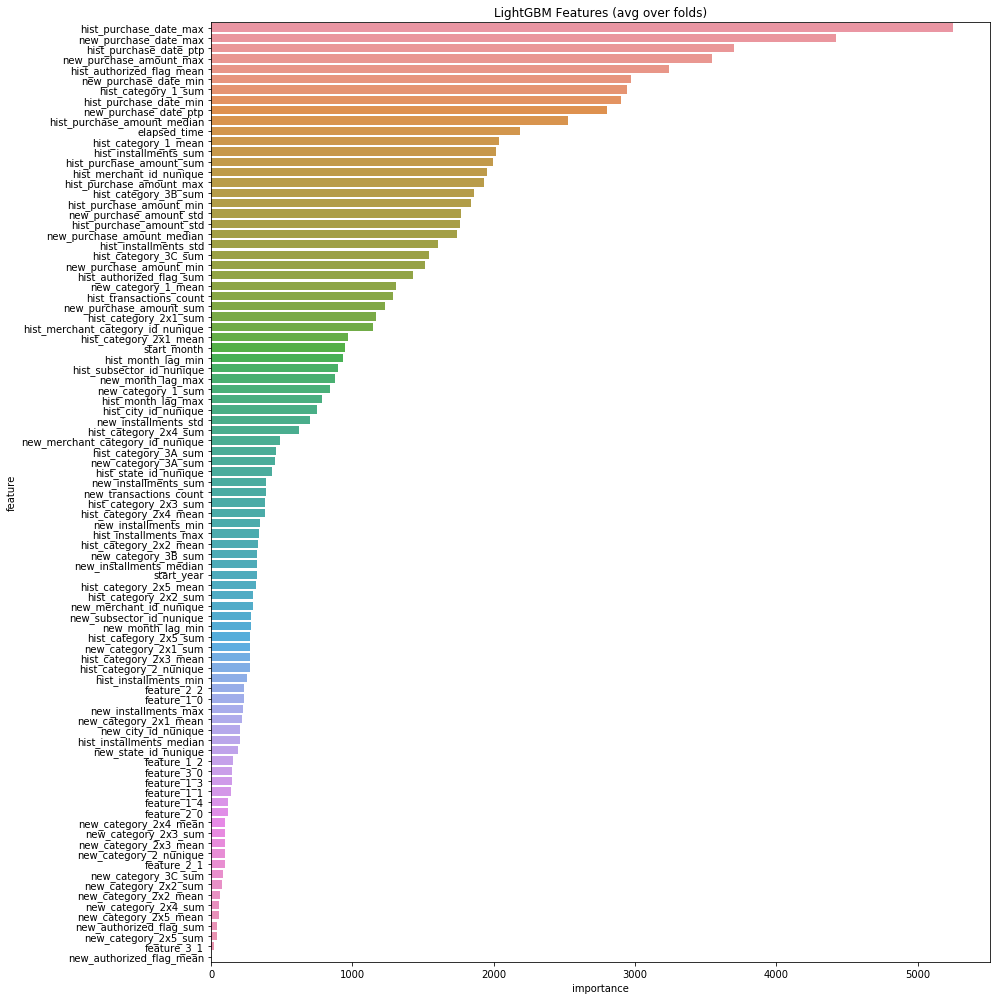

In [22]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [ ]:
xsub = pd.DataFrame()
xsub['card_id']  = id_test
xsub['target'] = mfull
xsub.to_csv('sub_lgb.csv', index = False)